In [1]:
import random
import h5py
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.preprocessing import StandardScaler
import math
import random
import copy
import os.path

from torch.utils.data import Dataset, DataLoader
import argparse

import torch
import torch.utils.data
from torch import nn
from torch.cuda import amp

import torchsparse
from torchsparse import SparseTensor
from torchsparse import nn as spnn
from torchsparse.utils.collate import sparse_collate, sparse_collate_fn
from torchsparse.utils.quantize import sparse_quantize

# User Input Desired Settings

In [2]:
# change file directory to the .h5 data file to convert
file = h5py.File('../mg22simulated/output_digi_HDF_Mg22_Ne20pp_8MeV.h5', 'r')

original_keys = list(file.keys())
original_length = len(original_keys)
# print(original_keys)

In [3]:
#making an array of the lengths of events
event_lens = np.zeros(original_length, int)
for i in range(original_length):
    event = original_keys[i]
    event_lens[i] = len(file[event])
    
discards = 0
for i in event_lens:
    if i < 128:
        discards += 1

print(discards)

6642


# Convert Raw H5 File into npArray with Corresponding key index

In [4]:
#making a numpy array of the data. three dimension are [event number, point within event, data value at point]
#length of each event is based on the longest event in dataset, so non-maximal events are padded with zeros at the end
#12th index of each data point now corresponds to the index of the event in the h5 file's original_keys
# each point thus contains:
# x,y,z, time, Amplitude, trackID (particle ID), pointID, energy, energy loss, angle, Mass, Atomic number, Event_id index
ISOTOPE = 'Mg22'
file_name = ISOTOPE + '_w_key_index'
# **only doing this if the file doens't exist already, as the conversion takes a while**
if not os.path.exists('../mg22simulated/' + file_name + '.npy'):
    event_data = np.zeros((original_length, np.max(event_lens), 13), float) 
    for n in tqdm.tqdm(range(len(original_keys))):
        name = original_keys[n]
        event = file[name]
        ev_len = len(event)
        #converting event into an array
        for i,e in enumerate(event):
            instant = np.array(list(e))
            event_data[n][i][:12] = np.array(instant)
            event_data[n][i][-1] = float(n) #insert index value to find corresponding event ID
    np.save('../mg22simulated/' + file_name, event_data)

In [5]:
data = np.load( '../mg22simulated/' + ISOTOPE + '_w_key_index' + '.npy')
assert data.shape == (original_length, np.max(event_lens), 13), 'Array has incorrect shape'
assert len(np.unique(data[:,:,12])) == original_length, 'Array has incorrect Event_ids'

In [23]:
# x,y,z, time, Amplitude, trackID (particle ID), pointID, energy, energy loss, angle, Mass, Atomic number, Event_id index
x = []
y = []
z = []
t = []
amp = []
track_id = []

print("Sorting Arrays")
for event in tqdm.tqdm(range(len(data))):
    for detection in data[event]:
        if not(detection[0] == 0. and detection[1] == 0. and detection[2] == 0. and detection[3] == 0. and detection[4] == 0.):
            x.append(detection[0])
            y.append(detection[1])
            z.append(detection[2])
            t.append(detection[3])
            amp.append(detection[4])
            track_id.append(detection[5])

100%|██████████| 10000/10000 [00:11<00:00, 882.41it/s]


# Random sample From New Numpy Array

In [7]:
def minmax(list):
    mn = min(list)
    mx = max(list)
    return mn, mx

def stdmean(list):
    std = np.std(list)
    mean = np.mean(list)
    return std, mean
 
#print(statistics(x)) # (-250.32000732421875, 250.32003784179688, 53.10198368892927, -0.24169623407507868)
#print(statistics(y)) # (-252.3749542236328, 252.3749542236328, 52.222182151246194, 0.5231569735677639)
#print(statistics(z)) # (-56.0, 897.6, 217.7207567223601, 515.003662529672)
#print(statistics(t)) # (20.0, 318.0, 68.03773647573753, 198.43864454052257)
#print(statistics(amp))  # (4.33970019971111, 28437.168639678683, 1651.0786362954818, 483.3103288726368)
#print(statistics(track_id))  # (0.0, 6.0, 1.465137242787051, 2.5601434323210155)
#print(statistics(pointID))  # (1.0, 4372.0, 867.8975845605485, 842.7817848384036)
#print(statistics(energy))  # (0.0, 101.66173143276683, 31.59588456346431, 16.38517271993762)
#print(statistics(energy_loss))  # (1.5686886456478533e-08, 0.0004088286077603698, 6.721297067500215e-05, 3.541481400602866e-05)
#print(statistics(angle)) # (0.0, 47.01561545484322, 8.101628726749576, 2.7313065828042116)
#print(statistics(mass)) # (1.0, 25.0, 7.413946945908423, 5.020969490577008)
#print(statistics(atomic_no)) # (1.0, 13.0, 3.8158895847231857, 2.938288801262519)

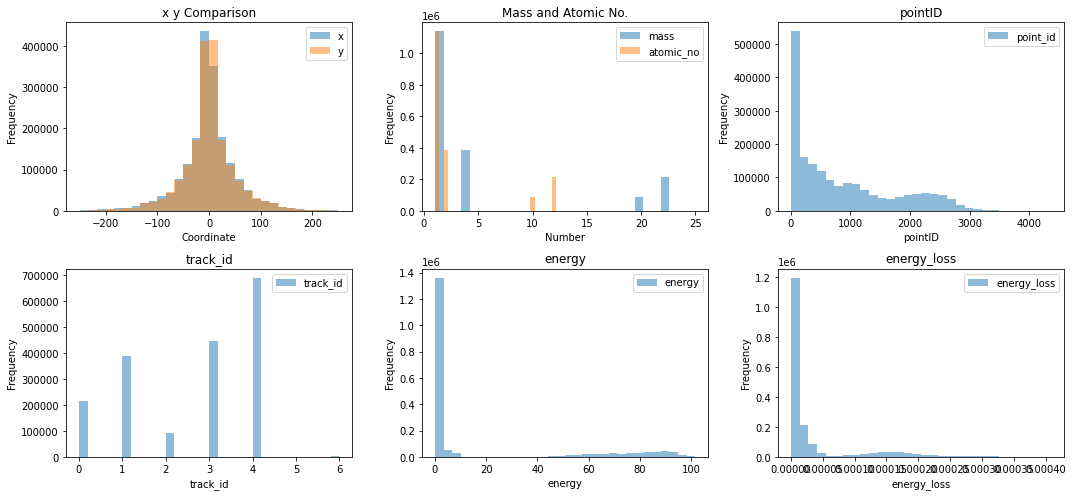

In [8]:
plt.figure(figsize=(15, 7))

plt.subplot(2, 3, 1)
plt.hist(x, bins=30, alpha=0.5, label='x')
plt.hist(y, bins=30, alpha=0.5, label='y')
plt.xlabel('Coordinate')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('x y Comparison')

plt.subplot(2, 3, 2)
plt.hist(mass, bins=30, alpha=0.5, label='mass')
plt.hist(atomic_no, bins=30, alpha=0.5, label='atomic_no')
plt.xlabel('Number')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Mass and Atomic No.')

plt.subplot(2, 3, 3)
plt.hist(pointID, bins=30, alpha=0.5, label='point_id')
plt.xlabel('pointID')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('pointID')

plt.subplot(2, 3, 4)
plt.hist(track_id, bins=30, alpha=0.5, label='track_id')
plt.xlabel('track_id')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('track_id')

plt.subplot(2, 3, 5)
plt.hist(energy, bins=30, alpha=0.5, label='energy')
plt.xlabel('energy')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('energy')

plt.subplot(2, 3, 6)
plt.hist(energy_loss, bins=30, alpha=0.5, label='energy_loss')
plt.xlabel('energy_loss')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('energy_loss')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [8]:
EVENTS = 10000 # total number of events
DETECTIONS = 1476 # total number of detections per event (even the empty ones)

x_array = np.zeros((EVENTS, DETECTIONS))
y_array = np.zeros((EVENTS, DETECTIONS))
z_array = np.zeros((EVENTS, DETECTIONS))
#t_array = np.zeros((10000, DETECTIONS))
amp_array = np.zeros((EVENTS, DETECTIONS))
track_id_array = np.zeros((EVENTS, DETECTIONS))
#pointID_array = np.zeros((10000, DETECTIONS))
#energy_array = np.zeros((10000, DETECTIONS))
#energy_loss_array = np.zeros((10000, DETECTIONS))
#angle_array = np.zeros((10000, DETECTIONS))
#mass_array = np.zeros((10000, DETECTIONS))
#atomic_no_array = np.zeros((10000, DETECTIONS))

for event in tqdm.tqdm(range(EVENTS)):
    for detection in range(DETECTIONS):
        # xyz
        x_array[event][detection] = data[event][detection][0]
        y_array[event][detection] = data[event][detection][1]
        z_array[event][detection] = data[event][detection][2]
        # feats
        #t_array[event][detection] = data[event][detection][3]
        amp_array[event][detection] = data[event][detection][4]
        track_id_array[event][detection] = data[event][detection][5]
        #pointID_array[event][detection] = data[event][detection][6]
        #energy_array[event][detection] = data[event][detection][7]
        #energy_loss_array[event][detection] = data[event][detection][8]
        #angle_array[event][detection] = data[event][detection][9]
        # labels?
        #mass_array[event][detection] = data[event][detection][10]
        #atomic_no_array[event][detection] = data[event][detection][11]
   

100%|██████████| 10000/10000 [00:45<00:00, 222.07it/s]


In [9]:
# linear fitting for xyz
def linearfit(x, min_orig, max_orig, min_desired, max_desired):
    return ((x - min_orig) / (max_orig - min_orig)) * (max_desired - min_desired) + min_desired

# normaliziation for features
def normalize(x, stddev, mean):
    return (x - mean) / stddev

In [10]:
x_min, x_max = minmax(x)
y_min, y_max = minmax(y)
z_min, z_max = minmax(z)

x_fit = linearfit(x_array, x_min, x_max, 0, 499).astype(int)
y_fit = linearfit(y_array, y_min, y_max, 0, 499).astype(int)
z_fit = linearfit(z_array, z_min, z_max, 0, 499).astype(int) 

In [11]:
#t_std, t_mean = stdmean(t_array)
amp_std, amp_mean = stdmean(amp_array)
#track_id_std, track_id_mean = stdmean(track_id_array)
#pointID_std, pointID_mean = stdmean(pointID_array)
#energy_std, energy_mean = stdmean(energy_array)
#energy_loss_std, energy_loss_mean = stdmean(energy_loss_array)
#angle_std, angle_mean = stdmean(angle_array)

#t_fit = normalize(t_array, t_std, t_mean)
#track_id_fit = normalize(track_id, track_id_std, track_id_mean)
#pointID_fit = normalize(pointID_array, pointID_std, pointID_mean)
#energy_fit = normalize(energy_array, energy_std, energy_mean)
#energy_loss_fit = normalize(energy_loss_array, energy_loss_std, energy_loss_mean)
#angle_fit = normalize(angle_array, angle_std, angle_mean)

In [12]:
total_coords = np.stack((x_fit, y_fit, z_fit), axis=-1)
total_features = amp_array.reshape(10000, 1476, 1)
total_features = np.concatenate((total_coords, total_features), axis=2)
total_labels = track_id_array.reshape(10000, 1476, 1)

print(total_coords.shape)
print(total_features.shape)
print(total_labels.shape)

(10000, 1476, 3)
(10000, 1476, 4)
(10000, 1476, 1)


In [13]:
# Step 1: Create a custom dataset class
from typing import Any, Dict

class CustomDataset(Dataset):
    def __init__(self, coords, feats, labels):
        coords = torch.tensor(coords, dtype=torch.int)

        
        
        feats = torch.tensor(feats, dtype=torch.float)
        labels = torch.tensor(labels, dtype=torch.long)

        self.coords = coords
        self.feats = feats
        self.labels = labels
    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        return self.coords[idx], self.feats[idx], self.labels[idx]

In [14]:
from torch.cuda import amp
# GPU Settings
device = 'cuda'
amp_enabled = True

#model = nn.Sequential(
    #spnn.Conv3d(4, 32, 3),
    #spnn.BatchNorm(32),
    #spnn.ReLU(True),
    #spnn.Conv3d(32, 64, 2, stride=2),
    #spnn.BatchNorm(64),
    #spnn.ReLU(True),
    #spnn.Conv3d(64, 64, 2, stride=2, transposed=True),
    #spnn.BatchNorm(64),
    #spnn.ReLU(True),
    #spnn.Conv3d(64, 32, 3),
    #spnn.BatchNorm(32),
    #spnn.ReLU(True),
    #spnn.Conv3d(32, num_classes, 1),  # Adjust the number of output channels
#).to(device)

model = nn.Sequential(
    spnn.Conv3d(4, 32, 3),
    spnn.BatchNorm(32),
    spnn.ReLU(True),
    #spnn.Conv3d(32, 64, 2, stride=2),
    #spnn.BatchNorm(64),
    #spnn.ReLU(True),
    #spnn.Conv3d(64, 64, 2, stride=2, transposed=True),
    #spnn.BatchNorm(64),
    #spnn.ReLU(True),
    #spnn.Conv3d(64, 32, 3),
    #spnn.BatchNorm(32),
    #spnn.ReLU(True),
    #spnn.GlobalMaxPool(),  
    #nn.Flatten(start_dim=1),
    #nn.Linear(32, 5)
    spnn.Conv3d(32, 32, 3),
    spnn.BatchNorm(32),
    spnn.ReLU(True),
    spnn.Conv3d(32, 5, 1),
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scaler = amp.GradScaler(enabled=amp_enabled)

In [15]:
custom_dataset = CustomDataset(total_coords, total_features, total_labels)

batch_size = 4
#num_workers = 4  

data_loader = DataLoader(
    custom_dataset,
    batch_size=batch_size
)

In [16]:
for batch_idx, (batch_coords, batch_feats, batch_labels) in enumerate(data_loader):
    
    inputs_list = []
    labels_list = []
    
    for i in range(len(batch_coords)):
        inputs_sparse = SparseTensor(coords=batch_coords[i], feats=batch_feats[i])
        labels_sparse = SparseTensor(coords=batch_coords[i], feats=batch_labels[i])
        inputs_list.append(inputs_sparse)
        labels_list.append(labels_sparse)
        
    inputs = sparse_collate(inputs_list).to(device=device)
    labels = sparse_collate(labels_list).to(device=device)

    print(f"Batch {batch_idx + 1}:")
    
    with amp.autocast(enabled=amp_enabled):
        outputs = model(inputs)
        labelsloss = labels.feats.squeeze(-1)
        loss = criterion(outputs.feats, labelsloss)
    
    print(f'[step {batch_idx + 1}] loss = {loss.item()}')

    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    
    # For simplicity, let's break the loop after one iteration
    #if batch_idx == 2:
        #break

Batch 1:
[step 1] loss = 1.635019302368164
Batch 2:
[step 2] loss = 1.560409426689148
Batch 3:
[step 3] loss = 1.5811340808868408
Batch 4:


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


tensor([[ 5.5420e-01, -5.4443e-01,  5.3418e-01,  4.1821e-01, -1.5747e-01],
        [ 3.8145e+00, -2.8965e+00,  1.3843e-01, -2.6094e+00, -1.3828e+00],
        [ 3.5410e+00, -2.6914e+00,  1.2927e-01, -2.4297e+00, -1.2705e+00],
        ...,
        [ 1.7586e-03, -3.9139e-03,  8.3466e-03, -1.8539e-02,  1.4999e-02],
        [ 1.7586e-03, -3.9139e-03,  8.3466e-03, -1.8539e-02,  1.4999e-02],
        [ 1.7586e-03, -3.9139e-03,  8.3466e-03, -1.8539e-02,  1.4999e-02]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)
tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')


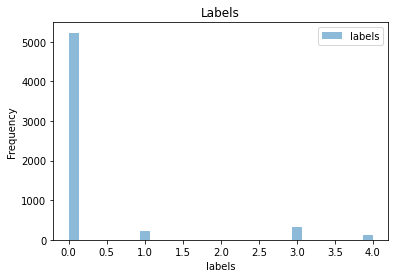

In [25]:
print(outputs.feats)
print(labels.feats)

plt.hist(labels.feats.cpu().numpy(), bins=30, alpha=0.5, label='labels')
plt.xlabel('labels')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Labels')

# Show the plots
plt.show()

In [ ]:
model.eval()
# enable fused and locality-aware memory access optimization
torchsparse.backends.benchmark = True  # type: ignore

with torch.no_grad():
    for k, feed_dict in enumerate(dataflow):
        inputs = feed_dict['input'].to(device=device).half()
        labels = feed_dict['label'].to(device=device)

        with amp.autocast(enabled=True):
            outputs = model(inputs)
            loss = criterion(outputs.feats, labels.feats)

        print(f'[inference step {k + 1}] loss = {loss.item()}')